In [1]:
#kaggle.json has to be in C:/users/skout/.kaggle
# ! pip install kaggle
# ! kaggle datasets download -d dgawlik/nyse
# ! unzip nyse.zip -d data_nyse
# ! rm nyse.zip
# ! ls
# ! pip install  matplotlib
# ! pip install  seaborn
##https://www.kaggle.com/dgawlik/nyse##

In [129]:
# ! pip install mpld3

In [137]:
import pandas as pd
import numpy as np

import mpld3#zoomable graphs
mpld3.enable_notebook()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
pd.set_option('display.max_columns', None)#Display all columns
pd.set_option('display.max_rows', None)#Display all columns

Context
This dataset is a playground for fundamental and technical analysis. It is said that 30% of traffic on stocks is already generated by machines, can trading be fully automated? If not, there is still a lot to learn from historical data.

Content
Dataset consists of following files:

*   **prices.csv**: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
*    **prices-split-adjusted.csv**: same as prices, but there have been added adjustments for splits.
*    **securities.csv**: general description of each company with division on sectors
*    **fundamentals.csv**: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.
Acknowledgements
Prices were fetched from Yahoo Finance, fundamentals are from Nasdaq Financials, extended by some fields from EDGAR SEC databases.

Inspiration
Here is couple of things one could try out with this data:

One day ahead prediction: Rolling Linear Regression, ARIMA, Neural Networks, LSTM
Momentum/Mean-Reversion Strategies
Security clustering, portfolio construction/hedging
Which company has biggest chance of being bankrupt? Which one is undervalued (how prices behaved afterwards), what is Return on Investment?

Import Data

In [3]:
prices_data_path = './data_nyse/prices.csv'
securities_data_path = './data_nyse/securities.csv'
prices_split_data_path = './data_nyse/prices-split-adjusted.csv'
fundamentals_data_path = './data_nyse/fundamentals.csv'


prices_data = pd.read_csv(prices_data_path)
securities_data = pd.read_csv(securities_data_path)
prices_split_data = pd.read_csv(prices_split_data_path)
fundamentals_data = pd.read_csv(fundamentals_data_path)

Inspect Data

In [4]:
prices_data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
securities_data.head()
print(securities)

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [6]:
prices_split_data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [9]:
fundamentals_data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.0,0.0,0.0,-1.020000e+09,197000000.0,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,11000000.0,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.0,0.0,0.0,2.208000e+09,660000000.0,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,481000000.0,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.0,0.0,0.0,1.700000e+08,-146000000.0,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,601000000.0,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322

Function to give us an idea of our Dataframes

In [43]:
def observe_data(dataframeName):
    dataframeName.info()
    print("Dataframe Shape: " + str(dataframeName.shape))
    print("Dataframe Size: " + str(dataframeName.size))
    print("Number Of Rows: " + str(len(dataframeName)))
    print("Number Of Columns: " + str(len(dataframeName.columns)))
    #used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values
    print(dataframeName.describe())#you can also pick specific columns as such: dataframe.columnName.describe()

In [44]:
observe_data(fundamentals_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 79 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Unnamed: 0                                           1781 non-null   int64  
 1   Ticker Symbol                                        1781 non-null   object 
 2   Period Ending                                        1781 non-null   object 
 3   Accounts Payable                                     1781 non-null   float64
 4   Accounts Receivable                                  1781 non-null   float64
 5   Add'l income/expense items                           1781 non-null   float64
 6   After Tax ROE                                        1781 non-null   float64
 7   Capital Expenditures                                 1781 non-null   float64
 8   Capital Surplus                                      1781 non-null  

Function plotting historical closing values of a specific company from *prices_split_data* dataframe

In [57]:
string = ', '.join(prices_split_data.symbol.unique())
print("The 500 companies are: " + string)

The 500 companies are: WLTW, A, AAL, AAP, AAPL, ABC, ABT, ACN, ADBE, ADI, ADM, ADP, ADS, ADSK, AEE, AEP, AES, AET, AFL, AGN, AIG, AIZ, AJG, AKAM, ALB, ALK, ALL, ALXN, AMAT, AME, AMG, AMGN, AMP, AMT, AMZN, AN, ANTM, AON, APA, APC, APD, APH, ARNC, ATVI, AVB, AVGO, AVY, AWK, AXP, AYI, AZO, BA, BAC, BAX, BBBY, BBT, BBY, BCR, BDX, BEN, BHI, BIIB, BK, BLK, BLL, BMY, BSX, BWA, BXP, C, CA, CAG, CAH, CAT, CB, CBG, CBS, CCI, CCL, CELG, CERN, CF, CHD, CHK, CHRW, CI, CINF, CL, CLX, CMA, CMCSA, CME, CMG, CMI, CMS, CNC, CNP, COF, COG, COH, COL, COO, COP, COST, CPB, CRM, CSCO, CSX, CTAS, CTL, CTSH, CTXS, CVS, CVX, CXO, D, DAL, DD, DE, DFS, DG, DGX, DHI, DHR, DIS, DISCA, DISCK, DLR, DLTR, DNB, DOV, DOW, DPS, DRI, DTE, DUK, DVA, DVN, EA, EBAY, ECL, ED, EFX, EIX, EL, EMN, EMR, ENDP, EOG, EQIX, EQR, EQT, ES, ESRX, ESS, ETFC, ETN, ETR, EW, EXC, EXPD, EXPE, EXR, F, FAST, FCX, FDX, FE, FFIV, FIS, FISV, FITB, FL, FLIR, FLR, FLS, FMC, FOX, FOXA, FRT, FSLR, FTI, FTR, GD, GE, GGP, GILD, GIS, GLW, GOOG, GOOGL, G

In [77]:
def plot_closing_values(company_name):    
    temp = prices_split_data.loc[prices_split_data["symbol"] == company_name]
    temp.close.plot()
    plt.title(company_name)
    plt.ylabel('Close')

In [81]:
! pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=691872d79b92c3ae286d8069e6c6c148efa068f159d56fb597afa85791e192bb
  Stored in directory: c:\users\skout\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [100]:
import plotly.graph_objects as go
def plot_candlestick_chart(company_name):    
    df = prices_split_data.loc[prices_split_data["symbol"] == company_name]
    fig = go.Figure(data=[go.Candlestick(x=df.date,
                    open=df.open,
                    high=df.high,
                    low=df.low,
                    close=df.close)])

    fig.show()

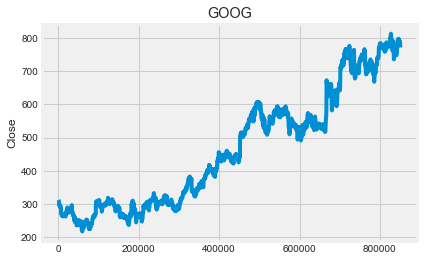

In [101]:
plot_closing_values("GOOG")

In [151]:
plot_candlestick_chart("GOOG")

A moving average (MA) is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random short-term price fluctuations.

In [149]:
def moving_average(company_name):
    df = prices_split_data.loc[prices_split_data["symbol"] == company_name]
    df = df[['close','date']]
    df.reset_index(level=0, inplace=True)
    plt.plot(df.date, df.close)
    plt.show()
    #SMA - Simple Moving Average
    rolling_mean = df.close.rolling(20).mean()
    rolling_mean2 = df.close.rolling(50).mean()
    rolling_mean3 = df.close.rolling(100).mean()
    plt.plot(df.date, df.close, label=str(company_name))
    plt.plot(df.date, rolling_mean, label=str(company_name+' 20 Day SMA'), color='orange')
    plt.plot(df.date, rolling_mean2, label=str(company_name+' 50 Day SMA'), color='magenta')
    plt.plot(df.date, rolling_mean3, label=str(company_name+' 100 Day SMA'), color='red')
    plt.legend(loc='upper left')
    plt.show()
    #EMA - Exponential Moving Average
    exp1 = df.close.ewm(span=20, adjust=False).mean()
    exp2 = df.close.ewm(span=50, adjust=False).mean()
    exp3 = df.close.ewm(span=100, adjust=False).mean()
    plt.plot(df.date, df.close, label=str(company_name))
    plt.plot(df.date, exp1, label=str(company_name+' 20 Day EMA'), color='orange')
    plt.plot(df.date, exp2, label=str(company_name+' 50 Day EMA'), color='magenta')
    plt.plot(df.date, exp3, label=str(company_name+' 100 Day EMA'), color='red')
    plt.legend(loc='upper left')
    plt.legend(loc='upper left')
    plt.show()


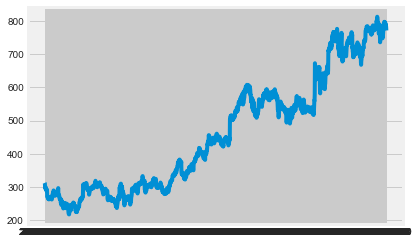

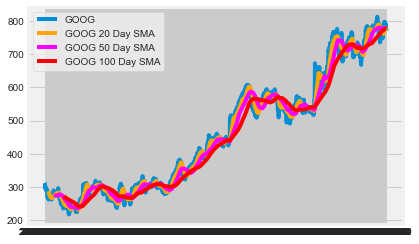

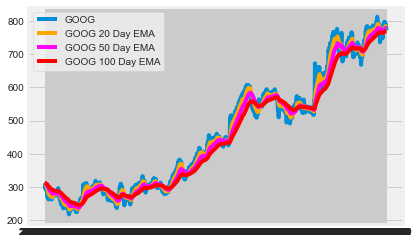

In [150]:
moving_average("GOOG")